# Superconductividad

En este notebook vamos a hacer un ejemplo de un Superconductor en una unión Normal - Superconductor (NS) para familiarizarnos con grados de libertad adicionales. Ya hemos visto un poco estos conceptos en el BHZ, en este caso los grados de libertad adicionales son las copias de *huecos* en el formalismo de Nambu.

Un Hamiltoniano en la base de Nambu, en el formalismo de Bogoliubov-de Gennes (BdG) tiene la siguiente estructura:

\begin{equation}
H_{BdG} = \begin{pmatrix}
H_0 - \mu & \Delta \\
\Delta^\dagger & \mu - \mathcal{T} H_0 \mathcal{T}^{-1}
\end{pmatrix}~.
\end{equation}

Vamos a emplear un $H_0$ sencillo, el de un metal y a ver el transporte en una unión metal - SC, el así conocido modelo de BTK (Blonder, Tinkham, Klapwijk).

En este modelo es interesante separar las probabilidades de reflexión en el contacto normal en $A = r^{eh}$ (reflexión de un electrón inyectado a un hueco) y $B = r^{eh}$ (reflexión de un electrón inyectado a un electrón).
En función de cómo de transparente es la unión NS (eso se cuantifica en $Z$, y en $T$) se obtienen reflexiones con esta pinta:
![BTKreflection](Figs/1-BTK-probab.png)

A partir de ellas, se obtiene la conductancia, tal que:
$ G_{NS} = \frac{2e^2}{h} (1-|r^{ee}|^2 + |r^{he}|^2 )$

![BTKreflection](Figs/1-BTK.png)

Figura de http://home.ustc.edu.cn/~zegang/pic/Andreev%20Reflection%20Lecture%20Notes.pdf

# Sistema NS en Kwant

In [1]:
## Importamos los módulos básicos:

import kwant #importamos kwant
import kwant.continuum #para los modelos continuos
import matplotlib.pyplot as plt #pyplot para los plots
import numpy as np #numpy para trabajar con vectores
import scipy as sp #scipy para diagonalizaciones, integraciones, etc
import sympy # importamos sympy para que las matrices se muestren mejor en el notebook
from sympy.abc import delta

sympy.init_printing()

import tinyarray
# Definimos las matrices de Pauli:
sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

Vamos a usar este tutorial también para profundizar un poco en las funciones que dependen del espacio. Consideramos como $H_0 = B (k_x^2 + k_y^2)$

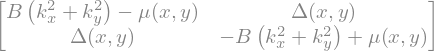

In [2]:
## Escribimos el Hamiltoniano
ham = """
   B * (k_x**2 + k_y**2) * sigma_z
   - mu(x,y) *sigma_z
   + Delta(x,y) * sigma_x
"""
ham = kwant.continuum.sympify(ham)
## Lo mostramos en pantalla:
ham

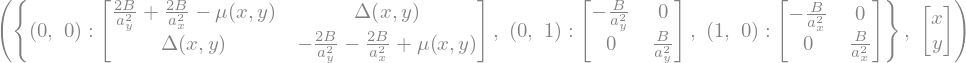

In [3]:
kwant.continuum.sympify(kwant.continuum.discretize_symbolic(ham))

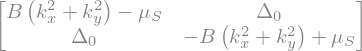

In [4]:
hamSC = """
   B * (k_x**2 + k_y**2) * sigma_z
   - mu_S *sigma_z
   + Delta_0 * sigma_x
"""
hamSC = kwant.continuum.sympify(hamSC)
hamSC

In [5]:
## Función para crear el sistema:

def make_nanoribbon(L, W, a):

    # 1) inicializamos un Builder y discretizamos el modelo
    # discretizamos en una red cuadrada de constante a
    model = kwant.continuum.discretize(ham, grid=a)
    modelSC = kwant.continuum.discretize(hamSC, grid=a)

    # 2) rellenamos el sistema con sitios de la red

    def shape_nanoribbon(site):
        x, y, = site.pos
        return 0 <= x <= L and 0 <= y <= W

    syst = kwant.Builder()

    ## El comando fill es el que emplearemos en este caso. (0,0) es el sitio por el que se empezará a rellenar el sistema
    syst.fill(model, shape_nanoribbon, (0, 0))

    # 3) Creamos el lead de contacto:
    # En este caso añadimos la simetría traslacional en -x

    lead_left = kwant.Builder(kwant.TranslationalSymmetry([-a, 0]),
                         conservation_law= - sigma_z)
    ## >>> IMPORTANTE: hemos incluido la conservation law para electrones y huecos!

    def shape_lead(site):
        x, y = site.pos
        return 0 <= y <= W

    lead_left.fill(model, shape_lead, (0, 0))
    syst.attach_lead(lead_left)
    lead_right = kwant.Builder(kwant.TranslationalSymmetry([a, 0]))
    lead_right.fill(modelSC, shape_lead, (L, 0))
    syst.attach_lead(lead_right)

    ## Como output sacamos el sistema finalizado y el lead izquierdo
    return syst.finalized(),  lead_left.finalized()

/home/yuriko/anaconda3/envs/Kenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Kwant's plotting functions have
the side effect of selecting the matplotlib backend. To avoid this warning,
import matplotlib.pyplot, matplotlib.backends or call matplotlib.use().
  This is separate from the ipykernel package so we can avoid doing imports until


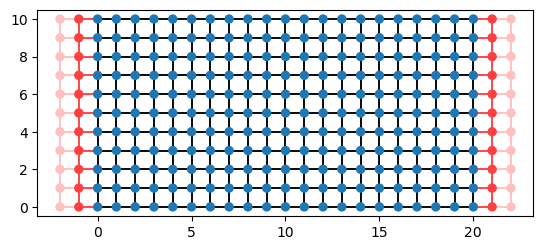

In [6]:
## Creamos una nanocinta de ejemplo
systf, lead = make_nanoribbon(L=20, W=10, a = 1)
kwant.plot(systf);

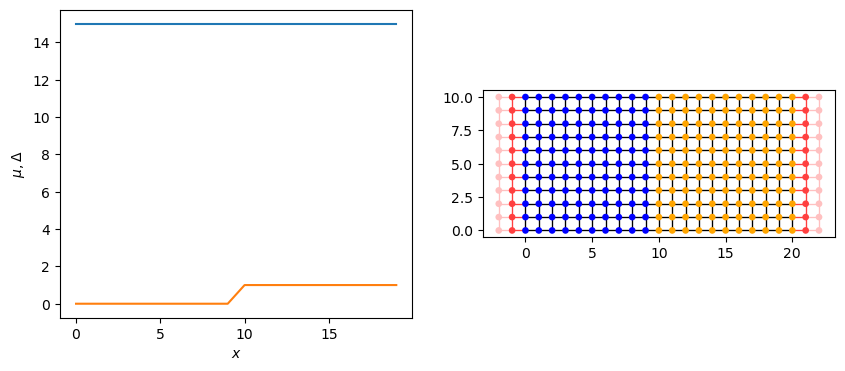

In [7]:

## Definimos ahora las zonas Normal y SC:
muS = 15
muN = 15
delta0 = 1
xNS = 10
def mu_func(x,y):
    if x < xNS:
        return muN
    else:
        return muS
def delta_func(x, y):
    if x < xNS:
        return 0
    else:
        return delta0

xs = np.arange(0, 20, 1)
fig, axs = plt.subplots(1,2,figsize=(10,4))
axs[0].plot(xs, [mu_func(xi, 0) for xi in xs])
axs[0].plot(xs, [delta_func(xi, 0) for xi in xs])
axs[0].set(xlabel = '$x$', ylabel ='$\mu, \Delta$')

def color_func(i):
    if systf.sites[i].pos[0] < xNS:
        return 'blue'
    else:
        return 'orange'
kwant.plot(systf, site_color = color_func, ax = axs[1]);
axs[1].set_aspect("equal")

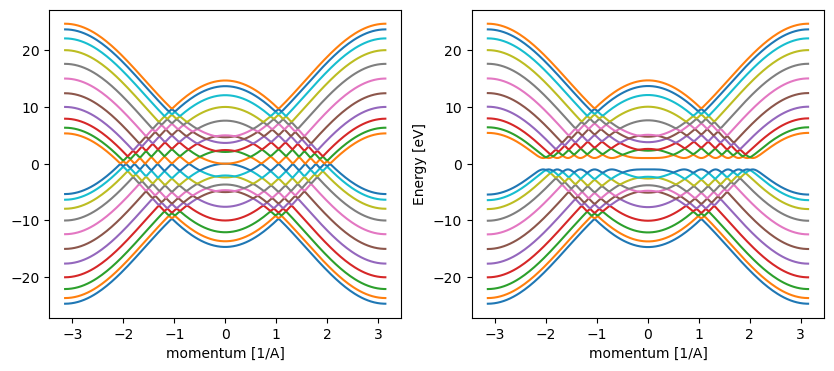

In [8]:
## Miremos primero las bandas de los leads:
fig, axs = plt.subplots(1,2,figsize=(10,4))
params = dict(B = 5, mu = mu_func, Delta = delta_func,
              mu_S = muS, Delta_0 = delta0)
kwant.plotter.bands(lead, params=params, momenta=np.linspace(-np.pi, np.pi, 201), show=False, ax = axs[0])
kwant.plotter.bands(systf.leads[1], params=params, momenta=np.linspace(-np.pi, np.pi, 201), show=False, ax = axs[1])
axs[0].set(xlabel=('momentum [1/A]'))
axs[1].set(xlabel = ('momentum [1/A]'),  ylabel=('Energy [eV]'))
plt.show()

## Conductancia y funciones de onda de scattering:

A continuación calculamos la conductancia, a través de `smatrix` y las funciones de onda de scattering.


In [9]:
## CONDUCTANCIA: Desglose de los comandos en clase
# >>>

def conductance(systf, energies, params,plot = True):
    cond = []
    ## compute the scattering matrix for a given energy
    for energy in energies:
        smatrix = kwant.smatrix(systf, params=params, energy=energy)
        cond.append(
            + smatrix.submatrix((0, 0), (0, 0)).shape[0]
            - smatrix.transmission((0, 0), (0, 0))
            + smatrix.transmission((0, 1), (0, 0)))
    if plot:
        fig, ax = plt.subplots(1,1,figsize = (8,4))
        ax.plot(energies, cond);
        ax.set( ylabel=  ('Conductance [e^2/h]'), xlabel = ('Energy'))
    return np.array(cond)

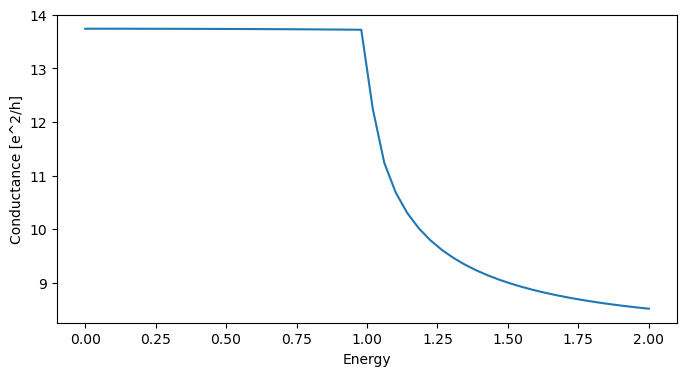

In [10]:
## Ejemplos conductancia:
energies = np.linspace(1e-4, 2)
g = conductance(systf, energies, params)
# t_h = conductance(systf, energies, params, lead_out = (0,1), lead_in = (0,0))

##  <span style="color:orange">Ejercicio 1: </span>
Modifica la función de conctancia y obtén separadamente la probabilidad de reflexión Andreev, y la probabilidad de reflexión normal


##  <span style="color:orange">Ejercicio 2: </span>
Modifica el código para tener dos valores de B en la zona metálica y en la zona superconductora. Qué le pasa a las probabilidades? Y a la conductancia?


##  <span style="color:orange">Ejercicio 3: </span>
Incluye una barrera entre la zona normal y el SC a partir de otro valor del potencial $\mu$.
**Pista** : separa la función de $mu(x)$ en tres regiones de x distintas.


##  <span style="color:orange">Ejercicio 4 (avanzado): </span>
Como idea puedes intentar cambiar el sistema metálico por un topological insulator como el que hemos visto en el tutorial anterior. Qué cosas cambiarán?